**Bibliotecas:**<br>
**matplotlib.pyplot**: Usado para criar gráficos, neste caso para plotar a trajetória do carro. <br>
**scipy.spatial.KDTree**: Uma estrutura de dados eficiente para encontrar vizinhos mais próximos, útil no algoritmo ICP. <br>
**trimesh**: Biblioteca para carregar e manipular objetos 3D e nuvens de pontos. <br>
**numpy**: Biblioteca fundamental para operações numéricas e manipulação de arrays.<br>
**os**: Biblioteca para manipulação de caminhos e arquivos no sistema operacional.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
!pip install trimesh
import trimesh
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.9/695.9 kB 11.2 MB/s eta 0:00:00


**load_point_cloud(filename)**: Função que carrega uma nuvem de pontos a partir de um arquivo .obj usando trimesh.<br>
 Retorna os vértices da nuvem de pontos para serem analisados, que no caso são as posições do carro.

In [2]:
def load_point_cloud(filename):
    return trimesh.load(filename).vertices

**compute_centroid(points):** Calcula o centróide de um conjunto de pontos, ou seja, a média das coordenadas dos pontos em cada eixo. O centróide é usado para centralizar os pontos antes de calcular a matriz de covariância, o que facilita a rotação e translação correta dos pontos.

In [3]:
def compute_centroid(points):
    return np.mean(points, axis=0)

**compute_covariance_matrix(points1, points2):** Calcula a matriz de covariância entre dois conjuntos de pontos, usados para alinhar points1 com points2. <br>
A matriz de covariância é essencial para determinar a melhor rotação e translação que alinham os pontos de origem (source_points) com os pontos alvo (target_points).

In [4]:
def compute_covariance_matrix(points1, points2):
    centroid1 = compute_centroid(points1)
    centroid2 = compute_centroid(points2)
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2
    return np.dot(centered_points1.T, centered_points2) / points1.shape[0]


**icp(source_points, target_points, max_iterations=50, tolerance=1e-5):** Implementa o algoritmo ICP. O ICP é usado para iterativamente alinhar duas nuvens de pontos (de um scan para o próximo) e calcular a transformação necessária. <br>

Inicializa uma matriz de transformação como a identidade. A matriz identidade é o ponto de partida, representando nenhuma transformação. Ela será ajustada iterativamente para alinhar as nuvens de pontos. <br> <br>
Para cada iteração, usa KD-Tree para encontrar os pontos mais próximos. O KD-Tree permite encontrar rapidamente os pontos mais próximos na nuvem de pontos alvo, essencial para o alinhamento ponto a ponto. <br> <br>
Calcula a matriz de covariância, decomposição SVD e a matriz de rotação R. A decomposição SVD da matriz de covariância ajuda a determinar a rotação que melhor alinha os pontos. <br> <br>
Calcula a translação t e atualiza a matriz de transformação. A translação t ajusta a posição dos pontos para melhor alinhamento após a rotação. <br><br>
Aplica a transformação aos source_points. Aplica a rotação e translação calculadas aos pontos de origem para alinhar com os pontos alvo. <br> <br>
Verifica o erro médio e para se estiver abaixo da tolerância. Monitora o progresso do algoritmo. Se o erro médio (diferença entre pontos correspondentes) é menor que a tolerância, o algoritmo para.

In [5]:
def icp(source_points, target_points, max_iterations=50, tolerance=1e-5):
    source_points = source_points.copy()
    target_points = target_points.copy()
    transformation_matrix = np.eye(4)

    for i in range(max_iterations):
        tree = KDTree(target_points)
        distances, indices = tree.query(source_points)
        closest_points = target_points[indices]

        H = compute_covariance_matrix(source_points, closest_points)
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)

        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = np.dot(Vt.T, U.T)

        t = compute_centroid(closest_points) - np.dot(R, compute_centroid(source_points))

        transformation = np.eye(4)
        transformation[:3, :3] = R
        transformation[:3, 3] = t

        source_points = np.dot(source_points, R.T) + t

        transformation_matrix = np.dot(transformation_matrix, transformation)

        mean_error = np.mean(distances)
        if mean_error < tolerance:
            break

    return transformation_matrix

**plot_trajectory(trajectory, ground_truth)**: Plota a trajetória estimada e a ground truth em um gráfico 3D para visualização e comparação dos resultados.

In [6]:
def plot_trajectory(trajectory, ground_truth):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Trajetória estimada para o carro após algoritmo', color='blue')
    ax.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], label='Ground Truth', color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

**main():** Função principal que carrega as nuvens de pontos e a ground truth, e aplica o ICP entre cada par de scans consecutivos. Organiza o fluxo geral do programa, desde o carregamento dos dados até a aplicação do ICP e a plotagem dos resultados. <br><br>

Define o número de scans e o caminho base dos arquivos. Especifica quantos scans serão processados e onde eles estão localizados. <br><br>
Carrega as nuvens de pontos em uma lista. Lê todas as nuvens de pontos em memória para processamento subsequente. <br><br>
Carrega a ground truth. Lê a trajetória de referência fornecida para comparação com a trajetória estimada. <br><br>
Inicializa a matriz de trajetória estimada. Prepara um array para armazenar as transformações acumuladas ao longo dos scans. <br><br>
Para cada par de scans consecutivos, aplica o ICP e atualiza a matriz de transformação acumulada. Calcula a transformação necessária para alinhar cada scan com o anterior e acumula essas transformações para obter a trajetória completa.<br><br>
Extrai as posições estimadas e da ground truth para plotagem. Preparando os dados para visualização. <br><br>
Plota as trajetórias para vizualizarmos a trajetória estimada em comparação com a ground truth para avaliar a precisão do algoritmo.

Processing scan 1
Processing scan 2
Processing scan 3
Processing scan 4
Processing scan 5
Processing scan 6
Processing scan 7
Processing scan 8
Processing scan 9
Processing scan 10
Processing scan 11
Processing scan 12
Processing scan 13
Processing scan 14
Processing scan 15
Processing scan 16
Processing scan 17
Processing scan 18
Processing scan 19
Processing scan 20
Processing scan 21
Processing scan 22
Processing scan 23
Processing scan 24
Processing scan 25
Processing scan 26
Processing scan 27
Processing scan 28
Processing scan 29


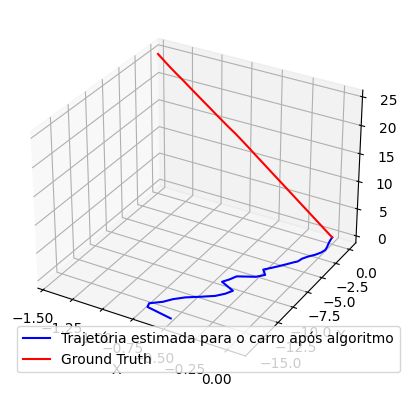

In [7]:
def main():
    num_scans = 30
    base_path = '/content/drive/MyDrive/Teste Daedalus/trajetoria/KITTI-Sequence'

    point_clouds = [
        load_point_cloud(os.path.join(base_path, f"{('000000' + str(i))[-6:]}", f"{('000000' + str(i))[-6:]}_points.obj"))
        for i in range(num_scans)
    ]

    ground_truth = np.load('/content/drive/MyDrive/Teste Daedalus/trajetoria/ground_truth.npy')

    estimated_trajectory = np.zeros((num_scans, 4, 4))
    estimated_trajectory[0] = np.eye(4)

    for i in range(1, num_scans):
        print(f"Processing scan {i}")
        transformation = icp(point_clouds[i - 1], point_clouds[i])
        estimated_trajectory[i] = np.dot(estimated_trajectory[i - 1], transformation)

    estimated_positions = estimated_trajectory[:, :3, 3]
    ground_truth_positions = ground_truth[:, :3, 3]

    plot_trajectory(estimated_positions, ground_truth_positions)

if __name__ == "__main__":
    main()

**Conclusão:** O código como um todo está estruturado para ler nuvens de pontos, aplicar o algoritmo ICP entre cada par de scans, e então plotar a trajetória estimada comparada com a ground truth fornecida. No entanto, os gráficos podem ficar desalinhados devido a vários fatores: <br><br>
Erros de Alinhamento Inicial, Limitações no ICP, Erros de Medição, Número de Iterações e Tolerância. <br><br>
Esses fatores podem fazer com que a trajetória estimada diverja da ground truth, resultando em gráficos desalinhados.